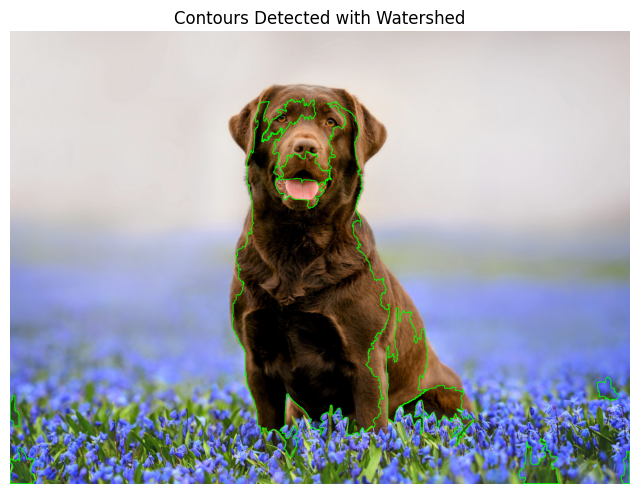

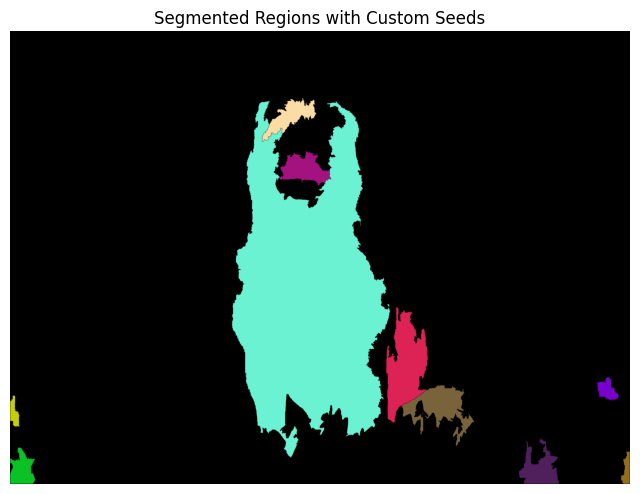

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(img, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def contour_detection_watershed(image_path):
    # Step 1: Read image
    img = cv2.imread("/content/dog.jpg")
    original = img.copy()

    # Step 2: Preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Step 3: Noise removal with morphological operations
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Step 4: Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Step 5: Sure foreground area using distance transform
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.2* dist_transform.max(), 255, 0)

    # Step 6: Unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Step 7: Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add 1 to all labels so that sure background is not 0
    markers = markers + 1

    # Mark the unknown region with 0
    markers[unknown == 255] = 0

    # Step 8: Apply Watershed
    markers = cv2.watershed(img, markers)
    img[markers == -1] = [0, 0, 255]  # Boundary in red

    result = np.zeros_like(img)
    for marker in range(2, np.max(markers) + 1):
        mask = np.uint8(markers == marker)
        color = np.random.randint(0, 255, size=3).tolist()
        result[mask == 1] = color

    # Overlay contours on original
    contours, _ = cv2.findContours(np.uint8(markers > 1), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(original, contours, -1, (0, 255, 0), 2)

    # Show results
    show_image(original, "Contours Detected with Watershed")
    show_image(result, "Segmented Regions with Custom Seeds")

contour_detection_watershed('/content/dog.jpg')

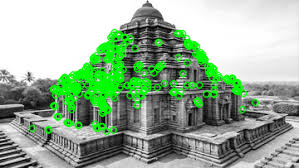

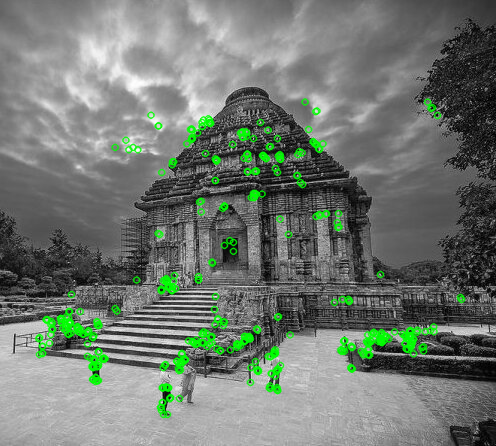

In [12]:
import cv2
from google.colab.patches import cv2_imshow
# Load the images
img1 = cv2.imread('image1.png', 0)
img2 = cv2.imread('image2.png', 0)

# Detect keypoints and descriptors using ORB
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Draw keypoints
img1_kp = cv2.drawKeypoints(img1, kp1, None, color=(0, 255, 0))
img2_kp = cv2.drawKeypoints(img2, kp2, None, color=(0, 255, 0))

# Display keypoints
cv2_imshow(img1_kp)
cv2_imshow(img2_kp)



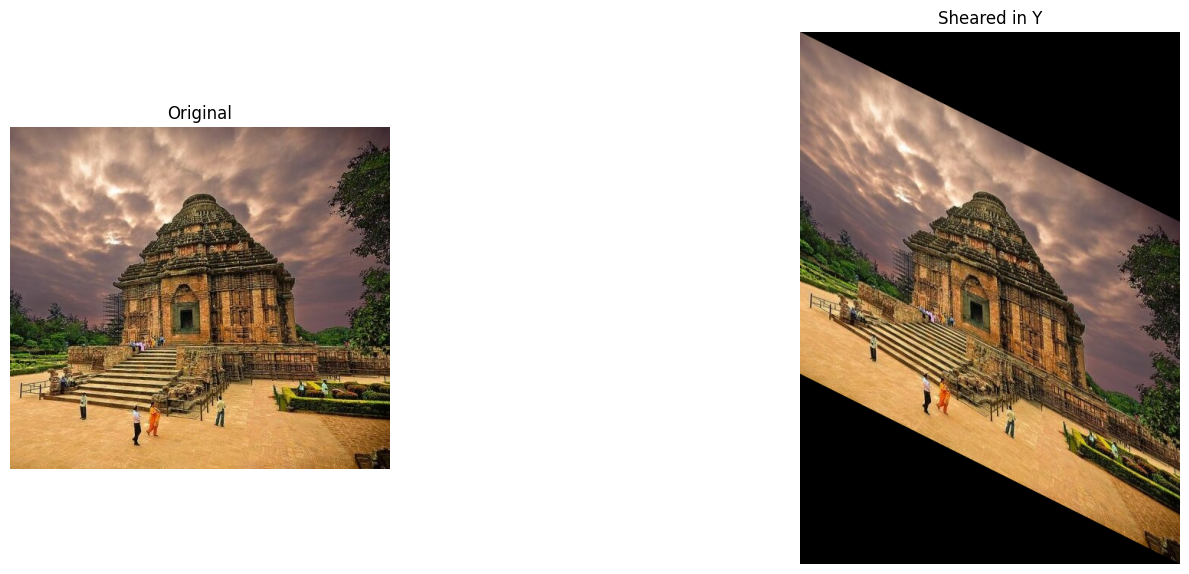

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread('/content/sun_temple_2.webp')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # For matplotlib

rows, cols = img.shape[:2]


# ----- Shear in Y direction -----
shear_y = 0.5
M_y = np.float32([[1,       0, 0],
                  [shear_y, 1, 0]])

sheared_y = cv2.warpAffine(img, M_y, (cols, int(rows + shear_y * cols)))

# ----- Display results -----
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sheared_y)
plt.title("Sheared in Y")
plt.axis('off')

plt.tight_layout()
plt.show()
cv2.imwrite('sheared_x.png', cv2.cvtColor(sheared_x, cv2.COLOR_RGB2BGR))


from google.colab import files
files.download("sheared_x.png")


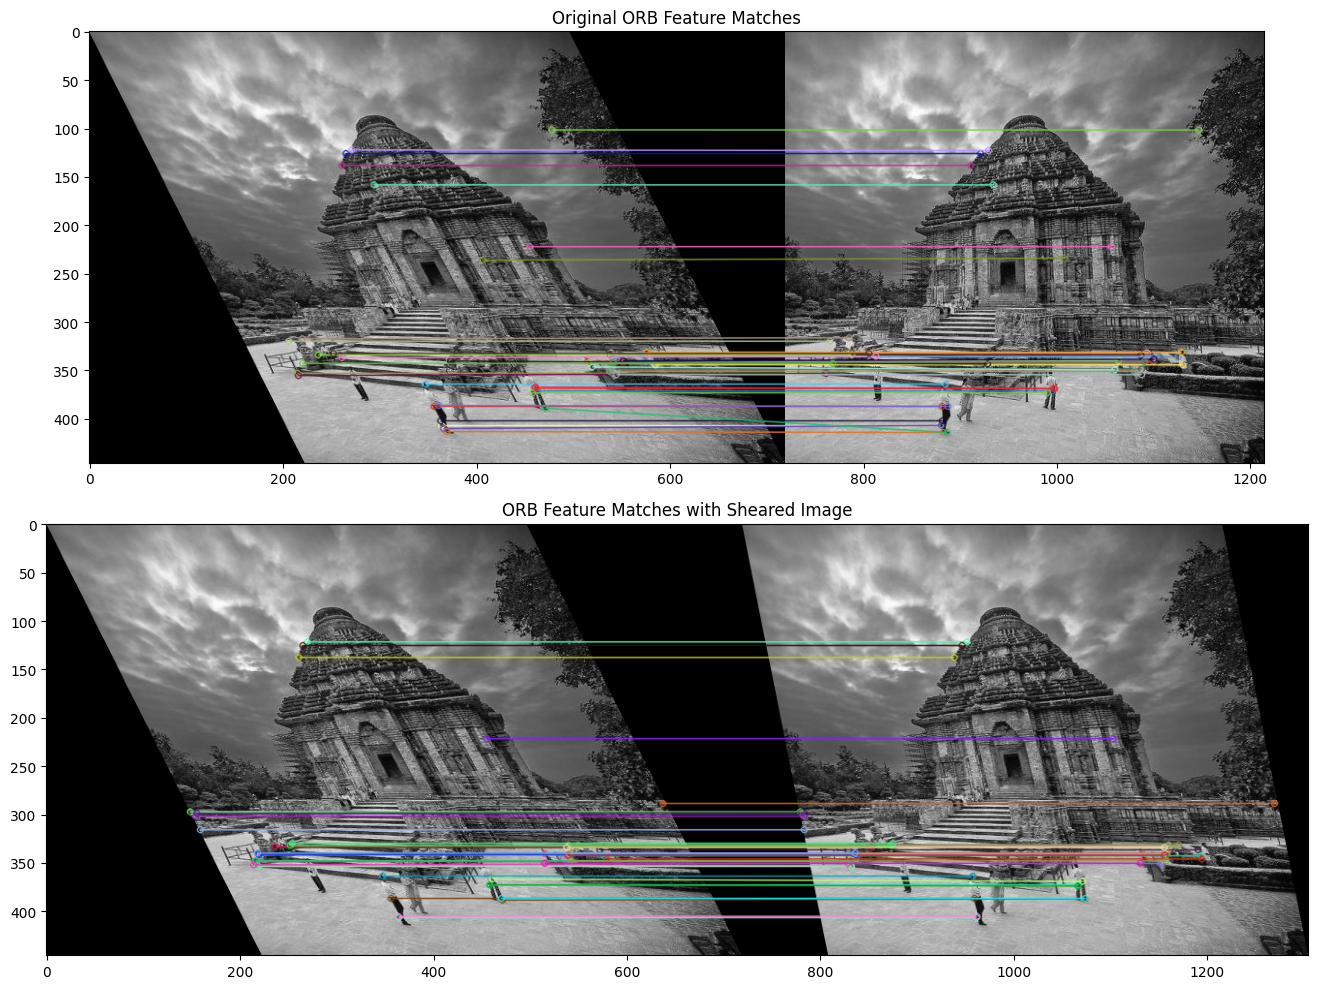

Original image 1: 500 keypoints
Original image 2: 500 keypoints
Sheared image 2: 500 keypoints
Original matching - good matches ratio: 50/500
Sheared matching - good matches ratio: 50/500


In [18]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load two images to match
img1 = cv.imread('/content/sheared_x.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('/content/sun_temple_2.webp', cv.IMREAD_GRAYSCALE)

# Get dimensions of img2
height, width = img2.shape

# Define shear matrix - adjust the 0.2 value to control the amount of shear
shear_factor = 0.2
M = np.float32([[1, shear_factor, 0],
                [0, 1, 0]])

# Apply shear transformation to img2
img2_sheared = cv.warpAffine(img2, M, (int(width + height*shear_factor), height))

# Initialize ORB detector
orb = cv.ORB_create()

# Find keypoints and descriptors for original img1 and sheared img2
kp1, des1 = orb.detectAndCompute(img1, None)
kp2_sheared, des2_sheared = orb.detectAndCompute(img2_sheared, None)

# Create BFMatcher (Brute Force Matcher) object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2_sheared)

# Sort them in order of their distance (lower distance = better match)
matches = sorted(matches, key=lambda x: x.distance)

# Draw first 50 matches
img_matches = cv.drawMatches(img1, kp1, img2_sheared, kp2_sheared, matches[:50], None,
                           flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# For comparison, let's also do matching with the original (non-sheared) image
kp2_orig, des2_orig = orb.detectAndCompute(img2, None)
matches_orig = bf.match(des1, des2_orig)
matches_orig = sorted(matches_orig, key=lambda x: x.distance)
img_matches_orig = cv.drawMatches(img1, kp1, img2, kp2_orig, matches_orig[:50], None,
                                flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the results
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.imshow(img_matches_orig)
plt.title('Original ORB Feature Matches')

plt.subplot(2, 1, 2)
plt.imshow(img_matches)
plt.title('ORB Feature Matches with Sheared Image')

plt.tight_layout()
plt.show()

# Print statistics about number of keypoints and good matches
print(f"Original image 1: {len(kp1)} keypoints")
print(f"Original image 2: {len(kp2_orig)} keypoints")
print(f"Sheared image 2: {len(kp2_sheared)} keypoints")
print(f"Original matching - good matches ratio: {len(matches_orig[:50])}/{min(len(kp1), len(kp2_orig))}")
print(f"Sheared matching - good matches ratio: {len(matches[:50])}/{min(len(kp1), len(kp2_sheared))}")

In [27]:
import cv2

# Loading the image
img = cv2.imread('/content/sun_temple_2.webp')

# Converting image to grayscale
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Applying SIFT detector
sift = cv.SIFT_create()
kp = sift.detect(gray, None)

# Marking the keypoint on the image using circles
img=cv2.drawKeypoints(gray ,
					kp ,
					img ,
					flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imwrite('image-with-keypoints.jpg', img)


True